# Cylindrical compressive test

In [ ]:
from ibvpy.bcond import BCSlice
from ibvpy.fets import FETS2D4Q
from ibvpy.tmodel.mats3D import MATS3DElastic
from bmcs_matmod.ms1.ms1 import MS13D
import bmcs_matmod.ms1.concrete_material_db as mp_db
from ibvpy.tmodel.viz3d_scalar_field import \
    Vis3DStateField, Viz3DScalarField
from ibvpy.tmodel.viz3d_tensor_field import \
    Vis3DTensorField, Viz3DTensorField
from mayavi import mlab
from ibvpy.sim.tstep_bc import TStepBC
from ibvpy.xmodel.xdomain_fe_grid_axisym import XDomainFEGridAxiSym

import numpy as np


## Current state of MS1 - FE implementation
 * Strong dependency on a time step in a post-peak regime
 * Energy control upon localization. Axisymmetric case seems to brittle - snap-back?
 * Kinks in a single point softening regime - can it be a source of convergence problems?
 * Slow convergence / in cct02 - changing 200 steps to 100 lead to a jump to a brittle branch
 * Localization - for the calibrated model - too brittle, some locking in postpeak branch
 * How to adjust dissipation energy in MS1 - r_T increases ductility but also strength

## Todo 
 * Visualization of damage in FE - what form to use?
 * Can k3d be used for this?
 * Does a regularization of MS1 make sense? Requires the energy fitting and scaling for N nd T (at least) - maybe also their combinations
 * Self-regularized, consistent damage functions for N and T might provide a significantly
   better control over the softening branch and over the convergence rate.  

In [18]:
from bmcs_expsim.utils.mlab_decorators import decorate_figure

In [19]:
inner_radius = 0
outer_radius = 75
height = 150

xmodel = XDomainFEGridAxiSym(coord_min=(0,inner_radius),
                             coord_max=(height,outer_radius),
                             shape=(15, 7),
                             integ_factor=2 * np.pi,
                             fets=FETS2D4Q())

In [20]:
mp_db.C40MS1['r_T'] = 6.3
mp_db.C40MS1

{'E': 37000.0,
 'nu': 0.2,
 'Ad': 800.0,
 'eps_0': 7e-05,
 'K_N': 14000.0,
 'sigma_N_0': 25.0,
 'gamma_N': 5000.0,
 'sigma_T_0': 2.2,
 'K_T': 1200.0,
 'gamma_T': 65000,
 'S_T': 0.0025,
 'c_T': 8.7,
 'r_T': 6.3,
 'm_T': 0.001,
 'p_T': 7.5}

In [21]:
tmodel = MS13D(**mp_db.C40MS1)
#tmodel = MATS3DElastic(E=1, nu=0.3)

w_max = height * -0.006
bc_ax_sym = BCSlice(slice=xmodel.mesh[:, 0, :, 0],
                 var='u', dims=[1], value=0)
bc_l_x = BCSlice(slice=xmodel.mesh[0, :, 0, :],
                  var='u', dims=[0], value=0.0)
bc_r_x = BCSlice(slice=xmodel.mesh[-1, :, -1, :],
                 var='u', dims=[0], value=w_max)
bc_r_y = BCSlice(slice=xmodel.mesh[-1, :, -1, :],
                  var='u', dims=[1], value=0)

In [22]:
m = TStepBC(
    domains=[(xmodel, tmodel)],
    bc=[bc_ax_sym, bc_l_x, bc_r_x] # , bc_r_y],
)

m.hist.vis_record = {
    'strain': Vis3DTensorField(var='eps_ab'),
    # 'stress': Vis3DTensorField(var='sig_ab'),
    #        'damage': Vis3DStateField(var='omega_a'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

In [23]:
w_steps = 100
s = m.sim
s.tloop.k_max = 400
s.tline.step = 1 / w_steps
s.tloop.verbose = True
s.run()

VAR
eps_ab
DOMAIN
{'eps_ab': <bound method MATSXDEval.get_eps_ab of <bmcs_matmod.ms1.ms1.MS13D object at 0x7fd39d545090>>, 'sig_ab': <bound method MATSXDEval.get_sig_ab of <bmcs_matmod.ms1.ms1.MS13D object at 0x7fd39d545090>>}
t:	 0.00(0), 
	 0.01(1), 
	 0.02(1), 
	 0.03(1), 
	 0.04(1), 
	 0.05(1), 
	 0.06(4), 
	 0.07(5), 
	 0.08(7), 
	 0.09(7), 
	 0.10(7), 
	 0.11(9), 
	 0.12(9), 
	 0.13(9), 
	 0.14(9), 
	 0.15(10), 
	 0.16(10), 
	 0.17(10), 
	 0.18(14), 
	 0.19(12), 
	 0.20(12), 
	 0.21(12), 
	 0.22(12), 
	 0.23(13), 
	 0.24(13), 
	 0.25(13), 
	 0.26(13), 
	 0.27(13), 
	 0.28(14), 
	 0.29(13), 
	 0.30(13), 
	 0.31(13), 
	 0.32(13), 
	 0.33(13), 
	 0.34(13), 
	 0.35(13), 
	 0.36(13), 
	 0.37(13), 
	 0.38(13), 
	 0.39(14), 
	 0.40(14), 
	 0.41(14), 
	 0.42(14), 
	 0.43(14), 
	 0.44(14), 
	 0.45(14), 
	 0.46(14), 
	 0.47(15), 
	 0.48(15), 
	 0.49(15), 
	 0.50(16), 
	 0.51(16), 
	 0.52(16), 
	 0.53(16), 
	 0.54(17), 
	 0.55(23), 
	 0.56(23), 
	 0.57(24), 
	 0.58(24), 
	 0.59(24), 
	 0.60

StopIteration: Warning: convergence not reached in 1000 iterations

In [24]:
F_to = m.hist.F_t
U_to = m.hist.U_t

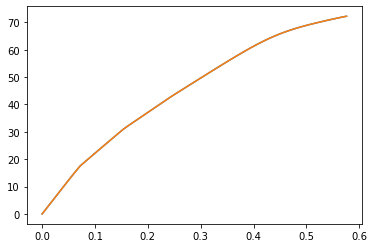

In [25]:
F_l_t = np.sum(F_to[:, bc_l_x.dofs], axis=-1)
F_r_t = np.sum(F_to[:, bc_r_x.dofs], axis=-1)
U_r_t = np.average(U_to[:, bc_r_x.dofs], axis=-1)

A = np.pi * outer_radius**2
import matplotlib.pylab as plt
plt.plot(-U_r_t, -F_r_t/A)
plt.plot(-U_r_t, F_l_t/A)

In [16]:

#mlab.options.backend = 'envisage'

f_strain = mlab.figure()
scene = mlab.get_engine().scenes[-1]
scene.name = 'strain'
strain_viz = Viz3DTensorField(vis3d=m.hist['strain'])
strain_viz.setup()

decorate_figure(f_strain, strain_viz, 200, [70, 20, 0])

# f_stress = mlab.figure()
# scene = mlab.get_engine().scenes[-1]
# scene.name = 'stress'
# stress_viz = Viz3DTensorField(vis3d=m.hist['stress'])
# stress_viz.setup()
#
# decorate_figure(f_stress, stress_viz, 200, [70, 20, 0])

mlab.show()